In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
#import requests # API library

import random
import time
import os

#from isoweek import Week

#import requests # API library

import numpy as np
import pandas as pd
import json
import re

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuide, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive



/tmp/ipykernel_3422/512193917.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model3(obs, ids1, ids2, num_coaches):
    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y


In [3]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

# tror noget gik galt med at gætte størrelser med en autoguide, så fik chatgpt til at lave en guide til os.
import pyro
import pyro.distributions as dist
import torch

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 12
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 407.97202014923096
Step 100 : loss = 6.726604342460632
Step 200 : loss = 5.330671310424805
Step 300 : loss = 2.5719096660614014
Step 400 : loss = -2.6544482707977295
Step 500 : loss = 8.023062348365784
Step 600 : loss = -1.5624809265136719
Step 700 : loss = 5.515195369720459
Step 800 : loss = 0.9911890029907227
Step 900 : loss = 6.437603235244751
Step 1000 : loss = 6.760784149169922
Step 1100 : loss = 4.366344690322876
Step 1200 : loss = 3.7742624282836914
Step 1300 : loss = 3.012615919113159
Step 1400 : loss = -0.5374319553375244
Step 1500 : loss = 1.1133358478546143
Step 1600 : loss = -0.8636457920074463
Step 1700 : loss = 7.282059192657471
Step 1800 : loss = 1.18092679977417
Step 1900 : loss = 1.7862296104431152
Step 2000 : loss = 0.3487679958343506
Step 2100 : loss = 0.20927047729492188
Step 2200 : loss = 0.40169286727905273
Step 2300 : loss = -0.4156050682067871
Step 2400 : loss = 3.295628547668457
Step 2500 : loss = 4.345042705535889
Step 2600 : loss = -1.15806102

In [4]:
from pyro.infer import Predictive

predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)


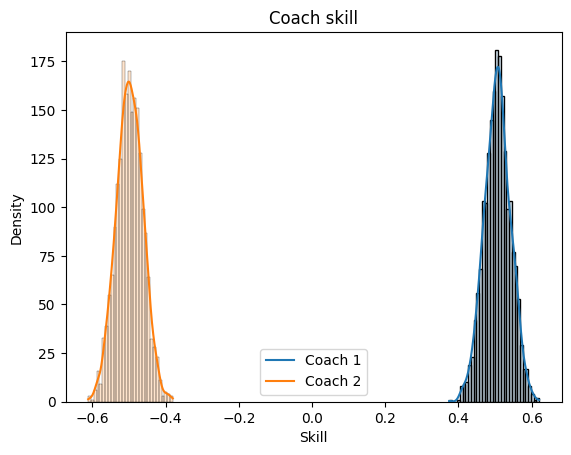

In [6]:
import seaborn as sns

coach1_skill = samples["coach_skills"].detach().squeeze()[:,0]
coach2_skill = samples["coach_skills"].detach().squeeze()[:,1]

sns.histplot(coach1_skill, kde=True, alpha=0.2)
sns.histplot(coach2_skill, kde=True, alpha=0.2)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.legend(["Coach 1", "Coach 2"])
plt.title("Coach skill")
plt.show()

Try and make some fake data with multiple players where the player with the higher index always wins.

In [7]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(0)
    else:
        obs.append(1)

obs = torch.tensor(obs)

In [8]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

import pyro
import pyro.distributions as dist
import torch

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 9.436192035675049
Step 100 : loss = 7.223379135131836
Step 200 : loss = 8.456393241882324
Step 300 : loss = 10.860042572021484
Step 400 : loss = 12.452561378479004
Step 500 : loss = 10.75575304031372
Step 600 : loss = 10.698718070983887
Step 700 : loss = 10.905665874481201
Step 800 : loss = 15.962547302246094
Step 900 : loss = 13.254022598266602
Step 1000 : loss = 5.163211345672607
Step 1100 : loss = 4.9386677742004395
Step 1200 : loss = 13.106970310211182
Step 1300 : loss = 7.42498254776001
Step 1400 : loss = 14.314699172973633
Step 1500 : loss = 13.70827031135559
Step 1600 : loss = 7.3231048583984375
Step 1700 : loss = 11.99179983139038
Step 1800 : loss = 21.223480701446533
Step 1900 : loss = 13.865809917449951
Step 2000 : loss = 10.966155529022217
Step 2100 : loss = 8.069495677947998
Step 2200 : loss = 11.797963619232178
Step 2300 : loss = 9.546464443206787
Step 2400 : loss = 8.41307020187378
Step 2500 : loss = 7.387151718139648
Step 2600 : loss = 8.896940231323242
S

In [12]:
coach_skill = samples["coach_skills"].detach().squeeze()
print(coach_skill.shape)


torch.Size([2000, 2])


0
1


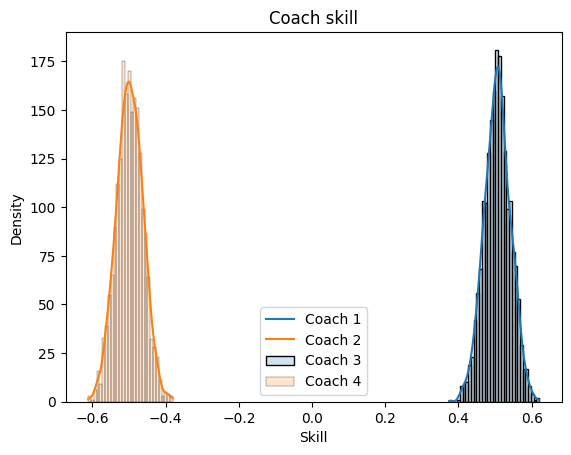

In [13]:
for i in range(2):
    print(i)
    coach_skill = samples["coach_skills"].detach().squeeze()[:,i]

    sns.histplot(coach_skill, kde=True, alpha=0.2)

plt.xlabel("Skill")
plt.ylabel("Density")
plt.legend(["Coach 1", "Coach 2", "Coach 3", "Coach 4", "Coach 5", "Coach 6"])
plt.title("Coach skill")
plt.show()
